# TOLIMAN Toy Model

This is a toy model for the proposed TOLIMAN space telescope, using the ``poppy`` package. Please see [the documentation](http://pythonhosted.org/poppy/) for full details in the API, and the SPIE papers by Perrin et al. ([2012](http://adsabs.harvard.edu/abs/2012SPIE.8442E..3DP), 2014) for further background information and discussion of algorithms. 

This .ipynb is cribbed from the excellent introductory notebook by Marshall Perrin available at http://nbviewer.jupyter.org/github/mperrin/poppy/blob/master/notebooks/POPPY_tutorial.ipynb. We are very grateful for the STSci team's great work on the ``poppy`` package! 

In [1]:
import poppy
import numpy as np
from astropy import *

from __future__ import (absolute_import, division, print_function, unicode_literals)
import scipy.special
import scipy.ndimage.interpolation
import matplotlib
import astropy.io.fits as fits
import astropy.units as u
import warnings
from poppy.poppy_core import OpticalElement, Wavefront, PlaneType, _PUPIL, _IMAGE, _RADIANStoARCSEC
from poppy import utils

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=12               #10 
matplotlib.rcParams['savefig.dpi']= 200             #72 

poppy.__version__

Populating the interactive namespace from numpy and matplotlib


u'0.6.0rc1'

For all of the following examples, you will have more informative text output when running the code if you first enable Python’s logging mechanism to display log messages to screen. This can sometimes be more verbose than is desired, so feel free to turn this on or off as desired. 

In [2]:
import logging
logging.getLogger('poppy').setLevel(logging.WARN)  
#Can be logging.CRITICAL, logging.WARN, logging.INFO, logging.DEBUG for increasingly verbose output

## Define a custom aperture for TOLIMAN

We want to have a non-centro-symmetric rosette of ellipses for TOLIMAN in order to avoid extensive nulls. We therefore need to define both an elliptical aperture, and a composite aperture which sums individual subapertures.

In [3]:

class EllipticalAperture(poppy.AnalyticOpticalElement):
    """ Defines an ideal circular pupil aperture
    Parameters
    ----------
    name : string
        Descriptive name
    radius : float
        Radius of the pupil, in meters. Default is 1.0
    pad_factor : float, optional
        Amount to oversize the wavefront array relative to this pupil.
        This is in practice not very useful, but it provides a straightforward way
        of verifying during code testing that the amount of padding (or size of the circle)
        does not make any numerical difference in the final result.
    """

    @utils.quantity_input(semimajor=u.meter)
    def __init__(self, name=None, semimajor=1.0*u.meter, ecc=0.5, pad_factor=1.0, planetype=PlaneType.unspecified, 
                 **kwargs):

        if name is None:
            name = "Ellipse, a={}, e={}".format(semimajor,ecc)
        super(EllipticalAperture, self).__init__(name=name, planetype=planetype, **kwargs)
        self.semimajor=semimajor
        self.ecc=ecc
        # for creating input wavefronts - let's pad a bit:
        self.pupil_diam = pad_factor * 2 * self.semimajor

    def get_transmission(self, wave):
        """ Compute the transmission inside/outside of the aperture.
        """
        if not isinstance(wave, Wavefront):  # pragma: no cover
            raise ValueError("CircularAperture get_transmission must be called with a Wavefront "
                             "to define the spacing")
        assert (wave.planetype != _IMAGE)

        y, x = self.get_coordinates(wave)
        semimajor = self.semimajor.to(u.meter).value
        semiminor = semimajor*(1.-self.ecc**2.)
        r = np.sqrt((x/semimajor) ** 2 + (y/semiminor) ** 2)
        del x
        del y

        w_outside = np.where(r > 1.)
        del r
        self.transmission = np.ones(wave.shape)
        self.transmission[w_outside] = 0
        return self.transmission


In [4]:
from poppy import AnalyticOpticalElement

In [5]:
class CompositeAnalyticOptic(AnalyticOpticalElement):
    """ Define a compound analytic optical element made up of the combination
    of two or more individual optical elements.
    This is just a convenience routine for semantic organization of optics.
    It can be useful to keep the list of optical planes cleaner, but
    you can certainly just add a whole bunch of planes all in a row without
    using this class to group them.
    All optics should be of the same plane type (pupil or image); propagation between
    different optics contained inside one compound is not supported.
    Parameters
    ----------
    opticslist : list
        A list of AnalyticOpticalElements to be merged together.
    """

    def _validate_only_analytic_optics(self, optics_list):
        for optic in optics_list:
            if isinstance(optic, AnalyticOpticalElement):
                continue  # analytic elements are allowed
            elif isinstance(optic, InverseTransmission):
                if isinstance(optic.uninverted_optic, AnalyticOpticalElement):
                    continue  # inverted elements are allowed, as long as they're analytic elements
                else:
                    return False  # inverted non-analytic elements aren't allowed, skip the rest
            else:
                return False  # no other types allowed, skip the rest of the list
        return True

    def __init__(self, opticslist=None, name="unnamed", verbose=True, **kwargs):
        if opticslist is None:
            raise ValueError("Missing required opticslist argument to CompoundAnalyticOptic")
        AnalyticOpticalElement.__init__(self, name=name, verbose=verbose, **kwargs)

        self.opticslist = []
        self._default_display_size = 3*u.arcsec
        self.planetype = None

        for optic in opticslist:
            if not self._validate_only_analytic_optics(opticslist):
                raise ValueError("Supplied optics list to CompoundAnalyticOptic can "
                                 "only contain AnalyticOptics")
            else:
                # if we are adding the first optic in the list, check what type of optical plane
                # it has
                # for subsequent optics, validate they have the same type
                if len(self.opticslist) == 0:
                    self.planetype = optic.planetype
                elif (self.planetype != optic.planetype and self.planetype != PlaneType.unspecified and
                        optic.planetype != PlaneType.unspecified):
                    raise ValueError("Cannot mix image plane and pupil plane optics in "
                                     "the same CompoundAnalyticOptic")

                self.opticslist.append(optic)
                if hasattr(optic, '_default_display_size'):
                    self._default_display_size = max(self._default_display_size,
                                                     optic._default_display_size)
                if hasattr(optic,'pupil_diam'):
                    if not hasattr(self,'pupil_diam'):
                        self.pupil_diam = optic.pupil_diam
                    else:
                        self.pupil_diam = max(self.pupil_diam, optic.pupil_diam)

        if self.planetype == _PUPIL:
            if all([hasattr(o, 'pupil_diam') for o in self.opticslist]):
                self.pupil_diam = np.asarray([o.pupil_diam.to(u.meter).value for o in self.opticslist]).max() * u.meter

    def get_transmission(self,wave):
        trans = np.zeros(wave.shape, dtype=np.float)
        for optic in self.opticslist:
            trans += optic.get_transmission(wave)
        return trans

    def get_opd(self,wave):
        opd = np.zeros(wave.shape, dtype=np.float)
        for optic in self.opticslist:
            opd += optic.get_opd(wave)
        return opd

    def get_phasor(self, wave):
        phasor = np.zeros(wave.shape, dtype=np.complex)
        for optic in self.opticslist:
            nextphasor = optic.get_phasor(wave)/float(len(self.opticslist))
            phasor += nextphasor
        return phasor

## Now let's generate an example rosette

In [6]:
symm = 5
radius = 0.3 # 30 cm
ecc = 0.8
semimajor = 0.065 # 7.5 cm


aps = []

for j in np.arange(symm):
    pa = 2.*np.pi/symm*(j+1.)
    xc, yc = radius*np.cos(pa), radius*np.sin(pa)
    aps.append(EllipticalAperture(semimajor=semimajor,ecc=ecc,shift_x=xc,shift_y=yc,rotation=180./np.pi*pa,
                                  pad_factor=6))

for j in np.arange(symm):
    pa = 2.*np.pi/symm*(j+1.) + np.pi/symm
    xc, yc = radius*np.cos(pa), radius*np.sin(pa)
    aps.append(EllipticalAperture(semimajor=semimajor,ecc=ecc,shift_x=xc,shift_y=yc,rotation=180./np.pi*pa +90.,
                                  pad_factor=6))

composite = CompositeAnalyticOptic(aps)
composite.name = 'TOLIMAN'

(<matplotlib.axes._subplots.AxesSubplot at 0x107a86850>,
 <matplotlib.axes._subplots.AxesSubplot at 0x104049d10>)

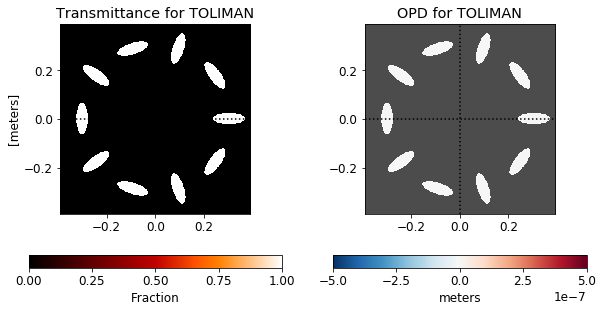

In [7]:
values = composite.sample(npix=2048)    # evaluate on 512 x 512 grid

plt.figure(figsize=(10,5))
composite.display(what='both')         # display phase and amplitude transmission;

## What does the PSF look like?

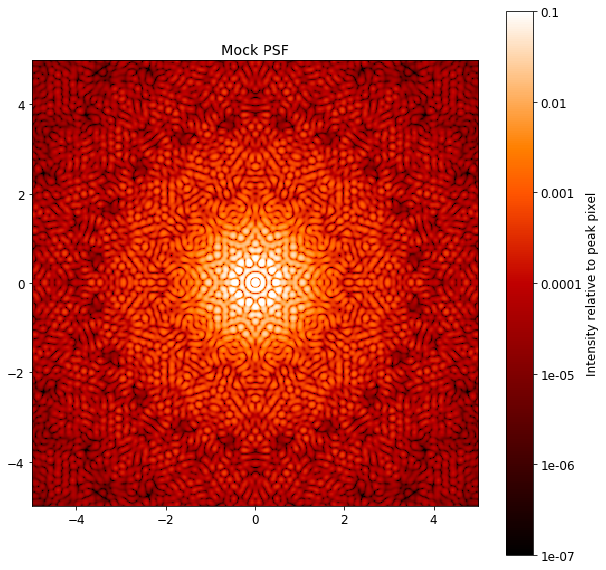

In [8]:
osys = poppy.OpticalSystem()
osys.add_pupil(composite)    # pupil radius in meters
osys.add_detector(pixelscale=0.050, fov_arcsec=10.0)  # image plane coordinates in arcseconds
wavelength=400e-9
psf = osys.calc_psf(wavelength)                            # wavelength in microns
poppy.display_psf(psf, title='Mock PSF',normalize='peak')

## How about the binary companion at ~ 4 as?

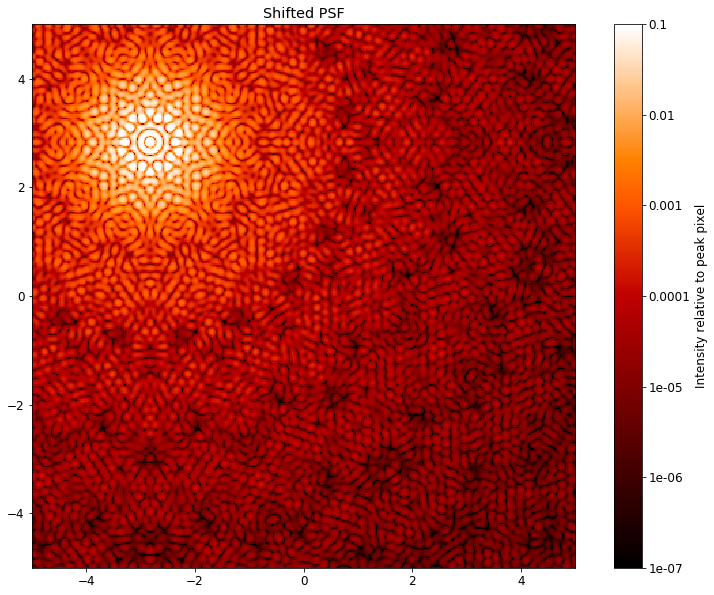

In [9]:
osys.source_offset_theta = 45.
osys.source_offset_r =  4.  # arcsec

plt.figure(figsize=(14,10))
psf2 = osys.calc_psf(wavelength=wavelength, display_intermediates=False)
poppy.display_psf(psf2, title='Shifted PSF',normalize='peak')

## Adding the two together...

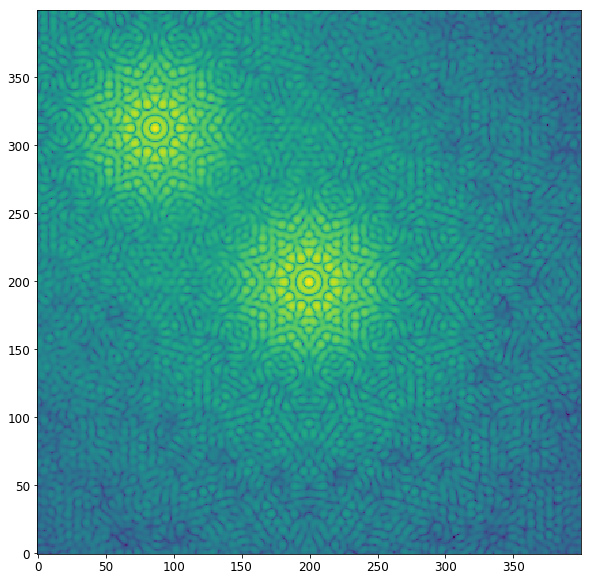

In [10]:
plt.imshow(np.log10(psf[0].data + 0.8*psf2[0].data))

## Working with PSFs

``poppy`` includes several utility functions for evaluating and displaying PSFs.  These all expect PSFs in the HDUlist format returned from ``poppy`` calculations, and use the FITS header metadata when rendering the display. 

We've already seen the ``display_PSF`` function. 

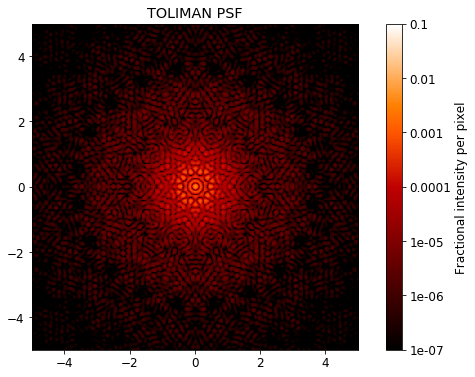

In [11]:
plt.figure(figsize=(10,6))
poppy.display_psf(psf, title='TOLIMAN PSF')

There is also a function for showing the difference between two PSFs. 

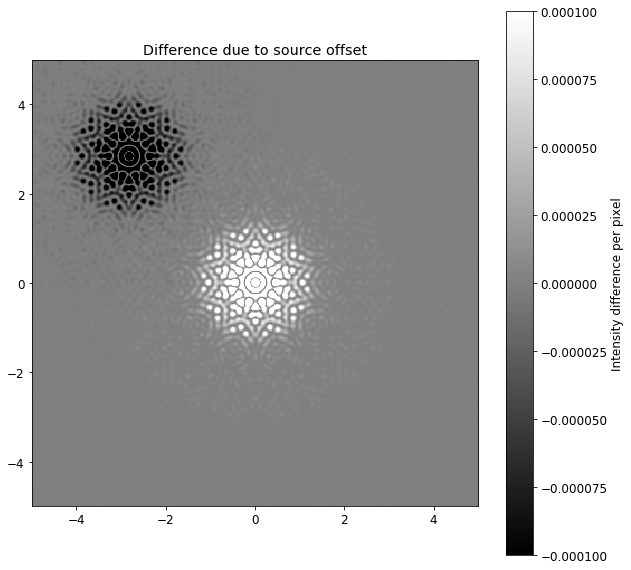

In [12]:
poppy.display_psf_difference(psf,psf2, title='Difference due to source offset')

And one for showing radial profiles:

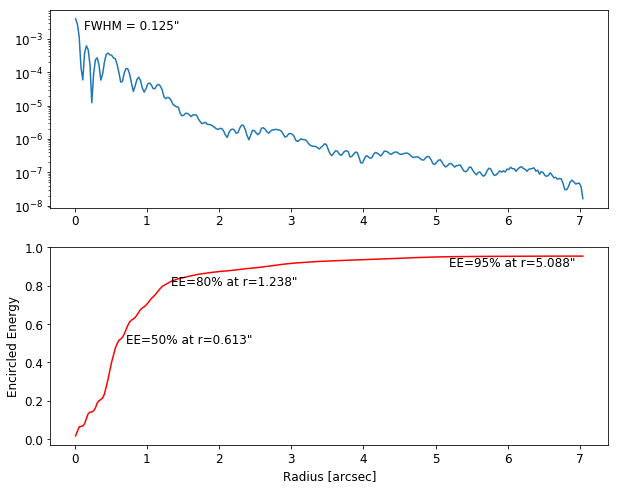

In [13]:
plt.figure(figsize=(10,8))
poppy.display_profiles(psf)

One can also make a variety of measurements, for instance the center. 

In this case, we see that for an even-sized array, the PSF is by default centered exactly in the middle between 4 pixels symmetrically.  (Remember that pixel centers have integer coordinates, so values ending in .5 are centered between adjacent pixels.)

In [14]:
print("The PSF array shape is ", psf[0].data.shape)
print("The centroid is located at ({0:.3f}, {1:.3f})".format(*poppy.measure_centroid(psf)))

The PSF array shape is  (400, 400)
Algorithm terminated at max iterations without convergence.
The centroid is located at (199.500, 199.466)


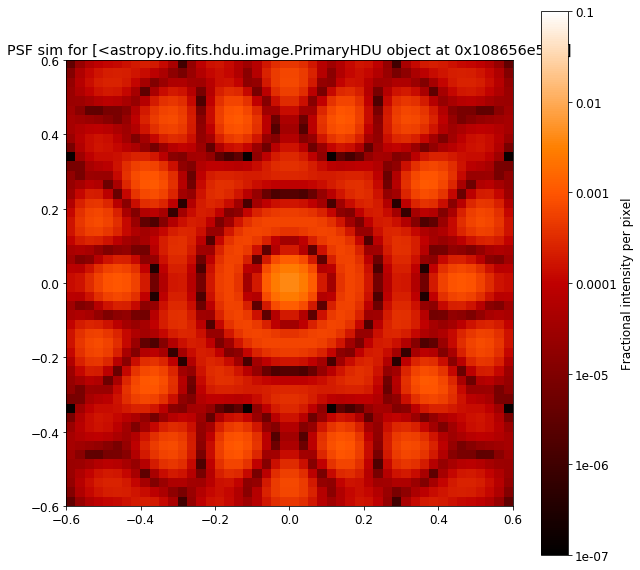

In [15]:
poppy.display_PSF(psf, imagecrop=1.2)

In [16]:
print("The FWHM is {0:.3f} arcsec at {1} microns ".format(poppy.measure_fwhm(psf), psf[0].header['WAVELEN']*1e6))

The FWHM is 0.100 arcsec at 0.4 microns 
